# Examining Brooklyn Data

First, it is necessary to import the packages needed for the analysis and visualizations.

In [85]:
import pandas as pd
import numpy as np
# Visualization packages
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import cm as cm
import graphviz
import datetime as dt
import random
# Analysis packages
from sklearn import datasets, linear_model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns

# Error/Score measurements
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance

%matplotlib inline

These are the functions needed for preparing the data when reading the data frame from the csv file. Performing all these functions at the beginning makes the code cleaner and more clearly arranged.
- time_of_day(hour) is dividing the hours of the day in bigger categories that we considered to be interesting when talking about (taxi) traffic.
- checkWeekday(day) checks if a day is a weekday or a weekend day
- calcMinSinceMidnight(dt) calculates the minutes that have passed since midnight from the datetime object
- groupMinSinceMidnight(m) categorizes the minutes since midnight column into larger intervals

In [2]:
# functions needed for data prep

def time_of_day(hour):
    if hour<6:
        return "night"
    elif hour<10:
        return "morning rush"
    elif hour<16:
        return "daytime"
    elif hour<19:
        return "evening_rush"
    else:
        return "night"
    
def checkWeekday(day):
    n = day.isoweekday()
    if n<6:
        return 1
    else:
        return 0
    
def calcMinSinceMidnight(dt):
    min_since_midnight = (dt.hour*60 + dt.minute)
    return min_since_midnight
    
def groupMinSinceMidnight(m):
    for minInt in range(0, 1445, 30):
        if m < minInt:
            return minInt

The steps for importing and preparing the data are the following:
1. Read the csv-file
2.  - As the columns have different names in the pickups and dropoffs datasets, one needs to first find the columns holding the certain values, as it is for example done here finding the 'datetime' column, giving it a more general name such that more generic functions can be performed on it.
    - The values in this datetime columns are then cast to datetime objects (they are strings when they are imported).
    - To order the rows by the datetime, this column is then set as an index. Later, the index is reset in order to make it easier to access the column.
3. A column just containing the date is added.
4. More general latitude and longitude columns are added (see 2. for how to find these)
5. A weekday column is added stating if the day is a weekday or not.
6. A time of day is assigned to each row.
7. The minutes since midnight are calculated and grouped in 30 minutes intervals.
8. The coordinates are collected in one 'location'-column.
9. Unused/ Useless columns are deleted.


In [3]:
def importAndPrepareData(filepath):
    # check if tsv or csv
    impdf = pd.read_csv(filepath, delimiter=',')
    
    datetimeCol = [col for col in impdf.columns if 'datetime' in col]
    impdf['datetime'] = impdf[datetimeCol[0]].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    impdf = impdf.set_index('datetime')
    impdf = impdf.reset_index()
    
    # add a column just containing the date
    impdf['date'] = impdf['datetime'].apply(lambda x: x.date())
    
    # more general lat and lon column names
    lonCol = [col for col in impdf.columns if 'longitude' in col]
    impdf['lon'] = impdf[lonCol[0]]
    latCol = [col for col in impdf.columns if 'latitude' in col]
    impdf['lat'] = impdf[latCol]
    
    # weekday or weekend-day?
    impdf['weekday'] = [checkWeekday(x) for x in impdf['datetime']]
    #TODO: add column saying if this day is an event day or not
    
    # assign time of day to each row
    impdf['time_of_day'] = [time_of_day(x) for x in impdf['datetime'].dt.hour]
    
    # calculate minutes since midnight for each row and group them
    impdf['min_since_midnight'] = [calcMinSinceMidnight(line) for line in impdf['datetime']]
    impdf['min_since_midnight_group'] = [groupMinSinceMidnight(m) for m in impdf['min_since_midnight']]
    
    # collect coordinates in one column
    impdf['location'] = np.nan
    loc = []
    for i in range(len(impdf['lat'].values)):
        loc.append((impdf['lon'].values[i], impdf['lat'].values[i]))
    impdf['location'] = loc
    
    randomCol = [col for col in impdf.columns if 'Unnamed' in col]
    for rc in randomCol: del impdf[rc]
    del impdf['min_since_midnight']

    return impdf

These steps are performed both on the Pickups_Brooklyn_June and the Dropoffs_Brooklyn_June dataset:

In [4]:
pickupDF = importAndPrepareData('Pickups_Brooklyn_June.csv')
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,0.70,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)"
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)"
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,5.56,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)"
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,4.20,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)"
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,2.30,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)"


In [5]:
dropoffDF = importAndPrepareData('Dropoffs_Brooklyn_June.csv')
dropoffDF.head()

,datetime,dropoff_datetime,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location
0,2016-06-09 21:35:11,2016-06-09 21:35:11,-73.981636,40.670242,1,22.0,4.00,0.0,27.30,1,5.22,2016-06-09,-73.981636,40.670242,1,night,1320,"(-73.9816360474, 40.6702423096)"
1,2016-06-09 21:23:55,2016-06-09 21:23:55,-74.011986,40.703773,1,17.0,3.65,0.0,21.95,1,5.10,2016-06-09,-74.011986,40.703773,1,night,1290,"(-74.0119857788, 40.7037734985)"
2,2016-06-09 21:34:55,2016-06-09 21:34:55,-73.993607,40.666752,1,20.5,2.50,0.0,24.30,1,5.60,2016-06-09,-73.993607,40.666752,1,night,1320,"(-73.9936065674, 40.6667518616)"
3,2016-06-09 21:22:19,2016-06-09 21:22:19,-73.983871,40.693539,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-73.983871,40.693539,1,night,1290,"(-73.98387146, 40.6935386658)"
4,2016-06-09 21:36:56,2016-06-09 21:36:56,-73.989677,40.703846,1,21.0,2.50,0.0,24.80,1,6.01,2016-06-09,-73.989677,40.703846,1,night,1320,"(-73.9896774292, 40.7038459778)"


After importing the data, we decided it would make sense to divide the places into areas. For this purpose, we use the KMeans algorithm to divide the area into evenly distributed clusters. We decided to divide the area into 10 clusters.

The function kmeansOnLocation(df, k=10) takes in a data frame and performs clustering by longitude and latitude. It then adds an extra column of the kmeans_cluster to the dataframe and returns both the modified dataframe and the kmeans object.

To examine how well the clustering is performed, we calculate the silhouette and distortion of the clustering:
The silhouette measures the between-cluster variability, that means, the distance in between the clusters. This should be maximized.
Distortion is a measure for the inter-cluster variability; how far the points in the cluster are away from each other. This should be minimized.

kmeansSilhouette(df) is used to calculate the silhouette. It takes in the data frame and first calculates the pairwise distances between each of the points, then, the silhouette_score function is used to calculate the silhouette. We use the 'manhattan' distance as metric for calculating the silhouette, as Brooklyn, like Manhattan, consists of blocks, so measuring the distance by blocks seems to make sense here.
The distortion can easily be retrieved by the .inertia property of the kmeans object.

In [6]:
def kmeansOnLocation(df, k=10):
    #perform kmeans
    K_allData = k
    k_allData = KMeans(K_allData, )
    k_allData.fit(df[['lat', 'lon']])
    
    # new column in dataframe for location cluster
    df['kmeans_cluster'] = k_allData.labels_
    
    # computing and printing the score of the clustering
    print('------Scores of K-Mean Clustering on dataframe ----------\n'+'silhouette:'+str(kmeansSilhouette(df))+
    '\n'+'distortion: '+str(k_allData.inertia_))
    
    return df, k_allData # returns df with added column from clustering

def kmeansSilhouette(df):
    sampledf = df.sample(n=1000)
    coords = []
    for i in range(len(sampledf['lon'].values)):
        coords.append([sampledf['lon'].values[i], sampledf['lat'].values[i]])
    pwdist = pairwise_distances(coords, metric='manhattan')
    silhouette_avg = silhouette_score(pwdist, sampledf['kmeans_cluster'], metric="precomputed")
    return silhouette_avg

def plotClusters(df, clusterCol='kmeans_cluster'):
    num_colors=len(set(df[clusterCol].values))
    colors=list(mcolors.CSS4_COLORS.keys())  #found this by searching "python color list"
    cluster_colors=random.choices(colors, k=num_colors)
    print(cluster_colors)
    x_=[]
    y_=[]
    c_=[]
    for label, x, y in zip(df[clusterCol].values, df['lon'].values, df['lat'].values):
        if label==-1:
            continue
        x_.append(x)
        y_.append(y)
        c_.append(cluster_colors[label])
        #plt.figure(figsize=(18, 12))
    plt.scatter(x_,y_,s=0.3,c=c_)

In [7]:
pickupDF, kPickup = kmeansOnLocation(pickupDF)

------Scores of K-Mean Clustering on dataframe ----------
silhouette:0.431451634396
distortion: 12.1062504633


['rosybrown', 'aquamarine', 'lightcyan', 'limegreen', 'greenyellow', 'darkgrey', 'linen', 'chocolate', 'wheat', 'gold']


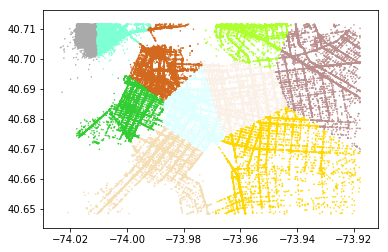

In [8]:
plotClusters(pickupDF)

------Scores of K-Mean Clustering on dataframe ----------
silhouette:0.535027578257
distortion: 39.7714837739
['khaki', 'dodgerblue', 'steelblue', 'oldlace', 'blanchedalmond', 'cornsilk', 'pink', 'royalblue', 'navajowhite', 'lightgrey']


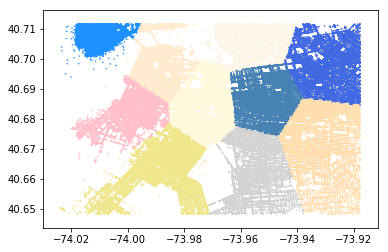

In [9]:
dropoffDF, kdropoff = kmeansOnLocation(dropoffDF)
plotClusters(dropoffDF)

In [10]:
dropoffDF.head()

,datetime,dropoff_datetime,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster
0,2016-06-09 21:35:11,2016-06-09 21:35:11,-73.981636,40.670242,1,22.0,4.00,0.0,27.30,1,5.22,2016-06-09,-73.981636,40.670242,1,night,1320,"(-73.9816360474, 40.6702423096)",0
1,2016-06-09 21:23:55,2016-06-09 21:23:55,-74.011986,40.703773,1,17.0,3.65,0.0,21.95,1,5.10,2016-06-09,-74.011986,40.703773,1,night,1290,"(-74.0119857788, 40.7037734985)",1
2,2016-06-09 21:34:55,2016-06-09 21:34:55,-73.993607,40.666752,1,20.5,2.50,0.0,24.30,1,5.60,2016-06-09,-73.993607,40.666752,1,night,1320,"(-73.9936065674, 40.6667518616)",0
3,2016-06-09 21:22:19,2016-06-09 21:22:19,-73.983871,40.693539,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-73.983871,40.693539,1,night,1290,"(-73.98387146, 40.6935386658)",4
4,2016-06-09 21:36:56,2016-06-09 21:36:56,-73.989677,40.703846,1,21.0,2.50,0.0,24.80,1,6.01,2016-06-09,-73.989677,40.703846,1,night,1320,"(-73.9896774292, 40.7038459778)",4


Another part to examine was the fact how many tips, if any, were given to the taxi drivers.
However, as the dataset contains negative fare_amounts, these should first be removed, as they should not be taken into consideration calculating the fare-tips-ratio.
The tips percentage is calculated, rounded to two decimals and added to the dataframe in another column. The tips_percentages with a value bigger than 1 are removed as it seems quite unlikely that someone would give more than 100 percent of tips.
As it does not make sense to use classes for each percentage of tips given, the percentage of tips given is again classified into a tipClass in steps of 5 percent (using classifyTips(tipPerc))

In [11]:
def calculateTipsPerc(fare, tips):
    return round(tips/fare, 2)

def classifyTips(tipPerc):
    if tipPerc <= 0.05:
        return 1
    elif tipPerc <= 0.1:
        return 2
    elif tipPerc <= 0.15:
        return 3
    elif tipPerc <= 0.2:
        return 4
    elif tipPerc <= 0.25:
        return 5
    elif tipPerc <= 0.3:
        return 6
    elif tipPerc <= 0.35:
        return 7
    else:
        return 8

def tipPreparation(df):
    # preparing data frame for analysis: removing negative and 0 fare_amounts
    df = df[df['fare_amount'] >0]
    
    # creating tip column percentage
    #tipsPerc = []
    #for x, y in zip(df['fare_amount'].values, df['tip_amount'].values):
    #    tipsPerc.append(round(calculateTipsPerc(x, y), 2))
        
    df['tips_perc'] = [round(tips/fare, 2) for fare, tips in zip(df['fare_amount'].values, df['tip_amount'].values)]
        
    # remove tips-perc that were more than 100%
    df = df[df['tips_perc'] <1]
    
    df['tipClass'] = [classifyTips(x) for x in df['tips_perc'].values]
    
    return df


def tipsHistPlot(df, col='tips_perc'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 160000, 20000))
    plt.hist(df[col], bins=20)
    plt.grid()
    plt.show()

In [12]:
pickupDF = tipPreparation(pickupDF)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,...,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster,tips_perc,tipClass
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,...,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)",5,0.40,8
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,...,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)",1,0.34,7
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,...,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)",5,0.21,5
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,...,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)",1,0.11,3
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,...,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)",7,0.09,2


Looking at the histogram of the observed percentages of tips given, it becomes more clear why a division into 5 percent steps seems logic in this context:

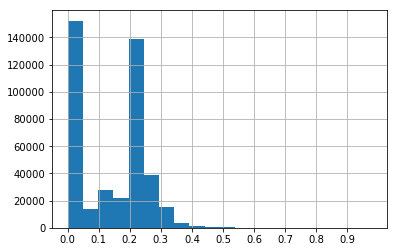

In [14]:
tipsHistPlot(pickupDF)

This is the histogram for the different classes of tips given:

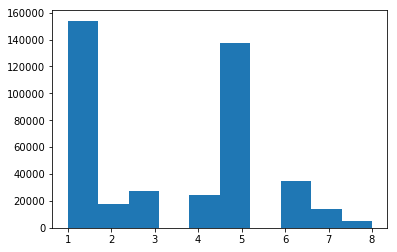

In [15]:
plt.hist(pickupDF['tipClass'])
plt.show()

In [16]:
pickupDF.columns

Index(['datetime', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'passenger_count', 'trip_distance', 'date', 'lon',
       'lat', 'weekday', 'time_of_day', 'min_since_midnight_group', 'location',
       'kmeans_cluster', 'tips_perc', 'tipClass'],
      dtype='object')

To create a model that can predict how much tip will be given, or rather, in which tip-cluster this trip will end up, we decided to use a RandomForestClassifier.
Before getting started, some of the columns need to be transformed into dummy variables as the numerical values would not make sense to use for these.

In [17]:
def createDummyDF(df):
    dummyColNames = ['payment_type', 'weekday', 'time_of_day', 'kmeans_cluster']
    df_with_dummies = pd.get_dummies(pickupDF, columns=dummyColNames)
    return df_with_dummies

In [18]:
pickupWithDummies = createDummyDF(pickupDF)
dropoffWithDummies = createDummyDF(dropoffDF)

In [19]:
def createTrainAndTestSets(df):
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    split=int(len(df_shuffled)*2/3)
    trainset=df_shuffled[:split]
    testset=df_shuffled[split:]
    return trainset, testset

In [20]:
def extractModelColumns(df):
    modelCols = ['trip_distance']
    modelCols.extend([col for col in df.columns if 'weekday_' in col])
    modelCols.extend([col for col in df.columns if 'payment_type_' in col])
    modelCols.extend([col for col in df.columns if 'passenger_count' in col])
    modelCols.extend([col for col in df.columns if 'kmeans_cluster_' in col])
    modelCols.extend([col for col in df.columns if 'time_of_day_' in col])
    return modelCols

In [21]:
def buildTipPredictionModel(dftrain, dftest, modelCols, alg='randomForest'):

    XTrain = dftrain[modelCols]
    targetTrain = dftrain['tipClass']
    XTest = dftest[modelCols]
    targetTest = dftest['tipClass']
    if alg=='randomForest':
        rfc = RandomForestClassifier(criterion='entropy') # entropy gives a better score for the first lassification with all the cols and does not make a difference for the second classification
        rfc.fit(XTrain, targetTrain)
        print("RandomForestClassifier with {} estimators".format(len(rfc.estimators_)))
        print("has a training score of "+ str(rfc.score(XTrain, targetTrain)))
        print("and a test score of "+str(rfc.score(XTest, targetTest)))
        print("\nFeatures and their importances:\n")
        for i in range(0, len(modelCols)):
            print(str(modelCols[i])+": "+str(rfc.feature_importances_[i]))
        return rfc
    
    elif alg=='decisionTree':
        dtc = DecisionTreeClassifier(max_depth=None)
        dtc.fit(XTrain, targetTrain)
        print("DecisionTreeClassifier with "+str(dtc.n_features_)+" features")
        print("has a training score of "+ str(dtc.score(XTrain, targetTrain)))
        print("and a test score of "+str(dtc.score(XTest, targetTest)))
        print("\nFeatures and their importances:\n")
        for i in range(0, len(modelCols)):
            print(str(modelCols[i])+": "+str(dtc.feature_importances_[i]))
        return dtc

In [22]:
def cmForTipClassifiers(df, classifier, modelCols):
    testPrediction = classifier.predict(df[modelCols])
    cm = confusion_matrix(df['tipClass'], testPrediction)
    labels = list(classifier.classes_)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [23]:
model1Cols = extractModelColumns(pickupWithDummies)

In [24]:
pickupDummiesTrain, pickupDummiesTest = createTrainAndTestSets(pickupWithDummies)

In [25]:
pickupDTC = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, model1Cols, alg='decisionTree')

DecisionTreeClassifier with 22 features
has a training score of 0.766557904843
and a test score of 0.592930000217

Features and their importances:

trip_distance: 0.257865938959
weekday_0: 0.00940432545116
weekday_1: 0.00883971990295
payment_type_1: 0.584956492654
payment_type_2: 2.98806270328e-08
payment_type_3: 0.0
payment_type_4: 0.0
passenger_count: 0.0730266910976
kmeans_cluster_0: 0.00266359892289
kmeans_cluster_1: 0.00458314171059
kmeans_cluster_2: 0.00460846385734
kmeans_cluster_3: 0.0043234436126
kmeans_cluster_4: 0.003299287253
kmeans_cluster_5: 0.00564362379893
kmeans_cluster_6: 0.00330296982727
kmeans_cluster_7: 0.00645741097767
kmeans_cluster_8: 0.00446396579736
kmeans_cluster_9: 0.00199410751222
time_of_day_daytime: 0.00612380554482
time_of_day_evening_rush: 0.00755739250916
time_of_day_morning rush: 0.00386884331972
time_of_day_night: 0.00701674741161


[[143436    364    544    483   8365    651    145     68]
 [   668   5298    561    394  10420    392    101     11]
 [   899    837   8050    652  16311    612    146     52]
 [   999    753   1127   7860  12557    687    151     54]
 [  4007   3420   5141   3695 117112   3143    810    292]
 [  1323    997   1550   1188  20318   9274    274    184]
 [   552    357    588    474   8733    801   2531     68]
 [   225     74    167    158   2804    617    104    958]]


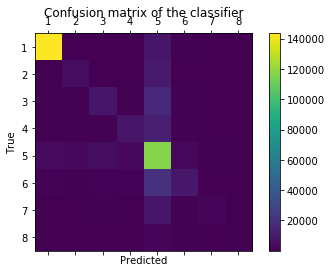

In [26]:
cmForTipClassifiers(pickupWithDummies, pickupDTC, model1Cols)

In [27]:
rfcdfwd = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, model1Cols)

RandomForestClassifier with 10 estimators
has a training score of 0.757548960867
and a test score of 0.601693508218

Features and their importances:

trip_distance: 0.488203208334
weekday_0: 0.0015780887355
weekday_1: 0.00154800274871
payment_type_1: 0.294642862127
payment_type_2: 0.150021616124
payment_type_3: 0.00187159020619
payment_type_4: 0.000621181805712
passenger_count: 0.0347872633482
kmeans_cluster_0: 0.001194640961
kmeans_cluster_1: 0.00277559313482
kmeans_cluster_2: 0.00166367756192
kmeans_cluster_3: 0.00174349623167
kmeans_cluster_4: 0.00131461798351
kmeans_cluster_5: 0.0025289913379
kmeans_cluster_6: 0.00133759132279
kmeans_cluster_7: 0.00194053724103
kmeans_cluster_8: 0.00154870108711
kmeans_cluster_9: 0.00139925962075
time_of_day_daytime: 0.00197755743483
time_of_day_evening_rush: 0.00169906143759
time_of_day_morning rush: 0.00276362819913
time_of_day_night: 0.00283883301634


[[141711    421    593    624   9321   1003    272    111]
 [   379   4125    564    503  11298    737    201     38]
 [   562    528   6480    801  17661   1132    298     97]
 [   626    518    772   7169  13631   1075    303     94]
 [  2515   2227   3573   3016 119150   5176   1482    481]
 [   800    621   1025    949  20404  10437    573    299]
 [   294    218    400    360   8740    936   3022    134]
 [   139     49    105    122   2749    671    129   1143]]


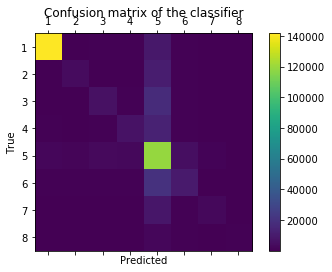

In [28]:
cmForTipClassifiers(pickupWithDummies, rfcdfwd, model1Cols)

As one can see here, the payment type and the trip distance have most importance on the tip given. So now we would like to find out how the score would look like taking into consideration only these columns when building a decision tree.

In [29]:
colsOfInterest = ['trip_distance']
colsOfInterest.extend([col for col in pickupWithDummies.columns if 'payment_type_' in col])

In [30]:
dt2 = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, colsOfInterest, alg='decisionTree')

DecisionTreeClassifier with 5 features
has a training score of 0.663640826109
and a test score of 0.657039320287

Features and their importances:

trip_distance: 0.0508969171471
payment_type_1: 0.949102604435
payment_type_2: 5.25134439092e-10
payment_type_3: 4.77892656331e-07
payment_type_4: 0.0


[[137086     16     57    318  16372    193      6      8]
 [   106    105     46    313  17237     32      5      1]
 [   143     27    261    474  26565     80      7      2]
 [   409     71    167   1751  21657    121      8      4]
 [   468     99    226   1262 135041    473     31     20]
 [   194     45     97    484  33685    584     10      9]
 [    64     10     37    145  13638    166     33     11]
 [    68      3      5     37   4761    200      8     25]]


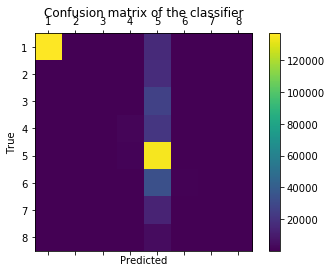

In [31]:
cmForTipClassifiers(pickupWithDummies, dt2, colsOfInterest)

In [32]:
rfc2 = buildTipPredictionModel(pickupDummiesTrain, pickupDummiesTest, colsOfInterest)

RandomForestClassifier with 10 estimators
has a training score of 0.663370124667
and a test score of 0.657356943312

Features and their importances:

trip_distance: 0.138690214241
payment_type_1: 0.248003934675
payment_type_2: 0.59910432297
payment_type_3: 0.012407895936
payment_type_4: 0.0017936321789


[[136956     25     56    323  16410    249     15     22]
 [    81     91     41    315  17250     54     12      1]
 [   105     20    207    503  26585    117     16      6]
 [   344     56    123   1711  21724    196     29      5]
 [   339     72    163   1237 135080    596     81     52]
 [   130     39     64    465  33646    695     26     43]
 [    34      8     24    132  13621    193     65     27]
 [    46      3      4     44   4717    227     16     50]]


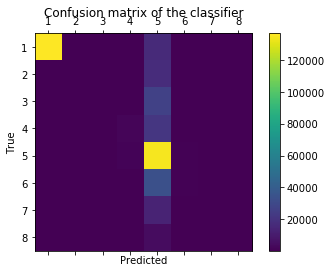

In [33]:
cmForTipClassifiers(pickupWithDummies, rfc2, colsOfInterest)

Looking at the scores, this model seems not to be overfitted, but it is not too good either...
It seems like the predictions for classes 1 and 5 are very good and the other ones are quite bad, probably because they have too few members in general to produce a good model, so the classification of the tips should be reconsidered.

In [34]:
#dot_data = tree.export_graphviz(dt2, out_file=None)  

#graph = graphviz.Source(dot_data)

#graph.view()

This one is unfortunately not working
import pydotplus
dt_graphviz = tree.export_graphviz(dt2, out_file = None)

pydot_graph = pydotplus.graph_from_dot_data(dt_graphviz)
from IPython.display import Image

Image(pydot_graph.create_png())

Prediction:

In [35]:
pdf1 = pickupWithDummies.head(1)

In [36]:
pred = rfcdfwd.predict(pdf1[model1Cols])
print(rfcdfwd.decision_path(pdf1[model1Cols]))

(<1x823048 sparse matrix of type '<class 'numpy.int64'>'
	with 214 stored elements in Compressed Sparse Row format>, array([     0,  83011, 165240, 247467, 329532, 411757, 493154, 575663,
       658150, 740925, 823048]))


In [37]:
def getCountsFromDF(df):
    df['count'] = 1
    countDF = pd.DataFrame.groupby(df,by=['date', 'min_since_midnight_group', 'kmeans_cluster']).sum()
    countDF = countDF.reset_index()
    columns = ['date', 'min_since_midnight_group', 'kmeans_cluster', 'count']
    countDF = countDF[columns]
    return countDF

In [38]:
countPickupDF = getCountsFromDF(pickupDF)

[]

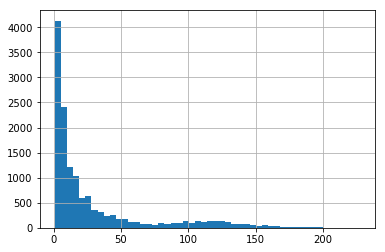

In [39]:
countPickupDF['count'].hist(bins=50).plot()

In [40]:
countPickupDF.head()

,date,min_since_midnight_group,kmeans_cluster,count
0,2016-06-01,30,0,17
1,2016-06-01,30,1,52
2,2016-06-01,30,2,18
3,2016-06-01,30,3,12
4,2016-06-01,30,4,20


In [41]:
countPickupDF["date;min_since_midnight"] = countPickupDF["date"].map(str) +';'+ countPickupDF["min_since_midnight_group"].map(str)

In [42]:
countPickupDF.head(12)

,date,min_since_midnight_group,kmeans_cluster,count,date;min_since_midnight
0,2016-06-01,30,0,17,2016-06-01;30
1,2016-06-01,30,1,52,2016-06-01;30
2,2016-06-01,30,2,18,2016-06-01;30
3,2016-06-01,30,3,12,2016-06-01;30
4,2016-06-01,30,4,20,2016-06-01;30
5,2016-06-01,30,5,37,2016-06-01;30
6,2016-06-01,30,6,13,2016-06-01;30
7,2016-06-01,30,7,20,2016-06-01;30
8,2016-06-01,30,8,9,2016-06-01;30
9,2016-06-01,30,9,12,2016-06-01;30


In [43]:
def buildDataFramesForClusterDF(df):
    # dictionary for clusters
    pickups_brooklyn_clusters = {}
    date = {}
    min_since_midnight = {}
    count = {}
    d = {}
    dft = {}
    for c in range(0, 10):
        pickups_brooklyn_clusters[c] = df[df['kmeans_cluster'] == c]
        date[c] = pickups_brooklyn_clusters[c]['date'].values
        min_since_midnight[c] = pickups_brooklyn_clusters[c]['min_since_midnight_group'].values
        count[c] = pickups_brooklyn_clusters[c]['count'].values
        d = {'date': date[c], 'min_since_midnight': min_since_midnight[c], 'count': count[c]}
        dft[c] = pd.DataFrame(d)
    
    mergedft = pd.merge(dft[0], dft[1], on=['date', 'min_since_midnight'], how='inner', suffixes=('_0', '_1'))
    
    for c in range(2, 10):
        mergedft = pd.merge(mergedft, dft[c], on=['date', 'min_since_midnight'], how='inner', suffixes=('', '_'+str(c)))
    mergedft = mergedft.rename(columns={'count': 'count_2'})

    return dft, mergedft

In [44]:
pickupCountDict, mergedPickupCountClusters = buildDataFramesForClusterDF(countPickupDF)

In [45]:
mergedPickupCountClusters.head()

,count_0,date,min_since_midnight,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9
0,17,2016-06-01,30,52,18,12,20,37,13,20,9,12
1,21,2016-06-01,60,34,27,4,12,22,16,20,10,10
2,19,2016-06-01,90,28,15,5,18,19,11,16,6,10
3,12,2016-06-01,120,27,12,5,6,17,10,6,4,7
4,7,2016-06-01,150,16,10,5,12,14,5,11,3,5


In [46]:
def plots(input_df, k):
    
    fig = plt.figure(figsize=(10, 10))
    
    # histogram
    ax1 = fig.add_subplot(221)
    input_df['count'].hist(bins=25)
    plt.ylabel('frequency')
    plt.xlabel('#pickups')
    plt.title('Histogram of pickup counts in area '+str(k))

    # scatterplot with colours

    ax3 = fig.add_subplot(222)
    ax3.scatter(range(len(input_df['count'])), input_df['count'], c=input_df['min_since_midnight'], s=10)
    plt.title('Pickup counts coloured according to minutes passed in area '+str(k))

    # plot with mean and quantiles 
    df_grouped = input_df.groupby('min_since_midnight').sum()
    df_grouped['means'] = input_df.groupby('min_since_midnight').mean()
    df_grouped['quantile_5'] = input_df.groupby('min_since_midnight').quantile(0.05)
    df_grouped['quantile_95'] = input_df.groupby('min_since_midnight').quantile(0.95)

    x = df_grouped.index
    
    ax4 = fig.add_subplot(223)
    ax4.plot(x, df_grouped.means, c='pink')
    ax4.plot(x, df_grouped.quantile_5, c='green')
    ax4.plot(x, df_grouped.quantile_95, c='orange')
    plt.xlabel('minutes since midnight')
    plt.ylabel('# pickups')
    plt.title('Average, percentile 5 and percentile 95 pickups on a day in area '+str(k))
    plt.legend()

In [47]:
list(pickupCountDict.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

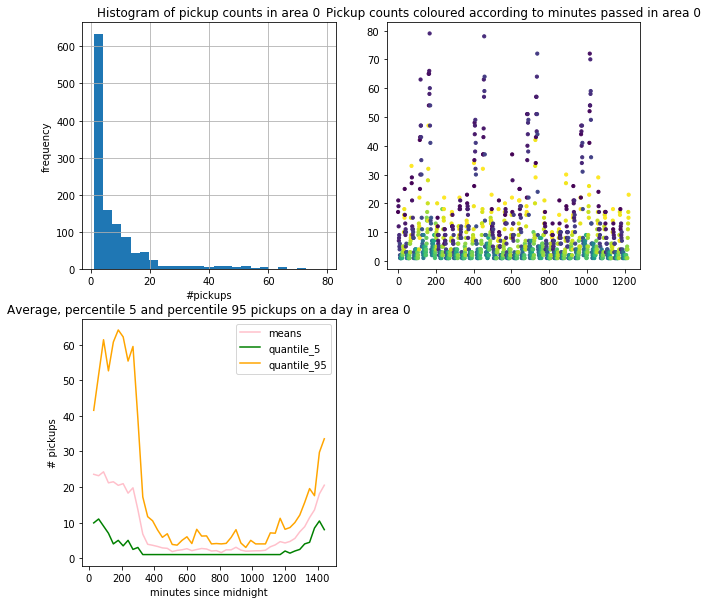

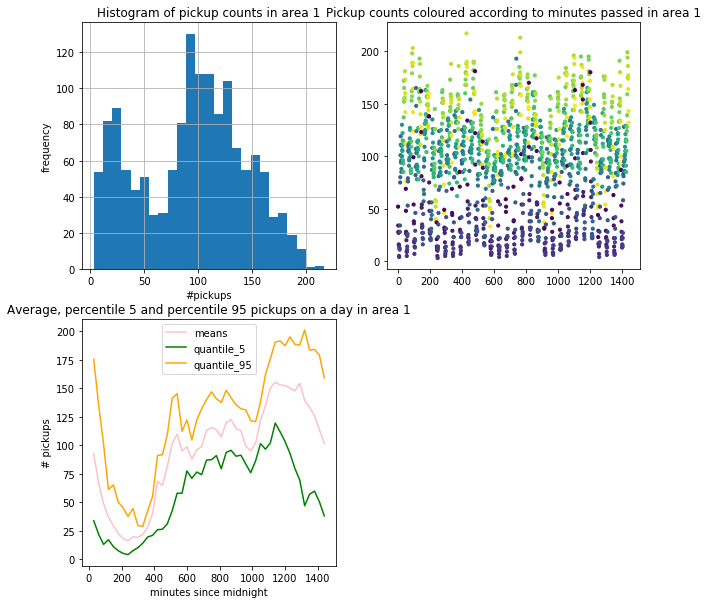

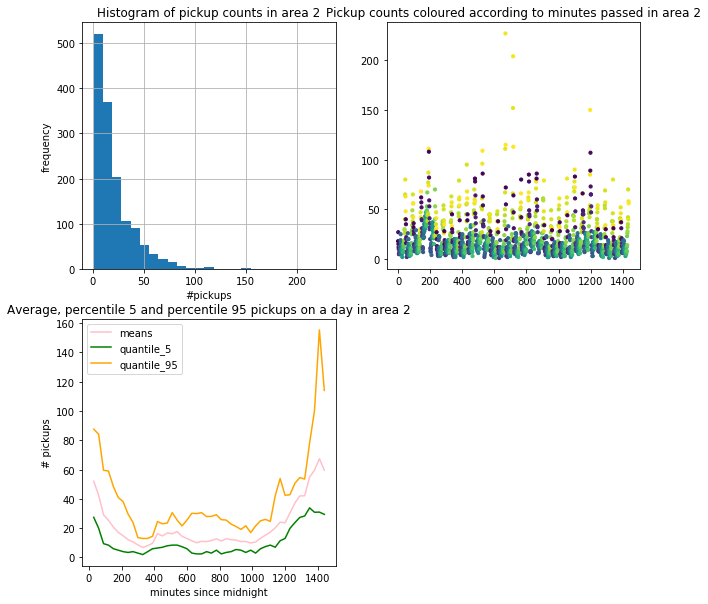

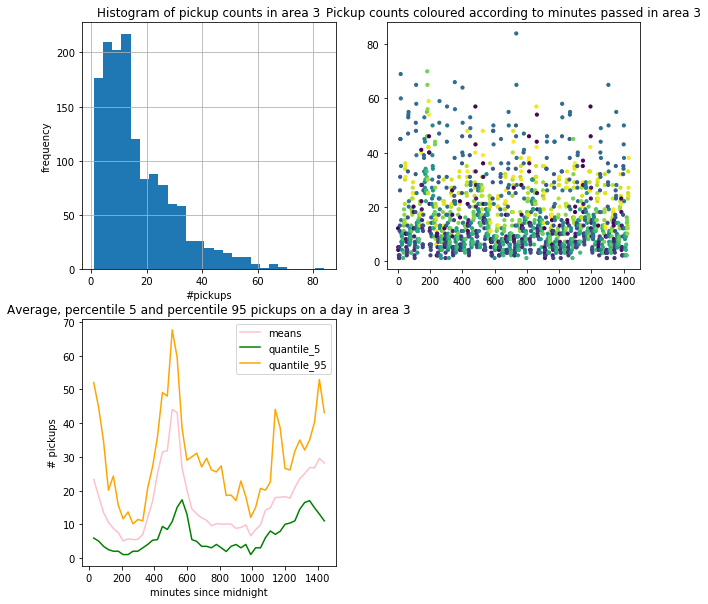

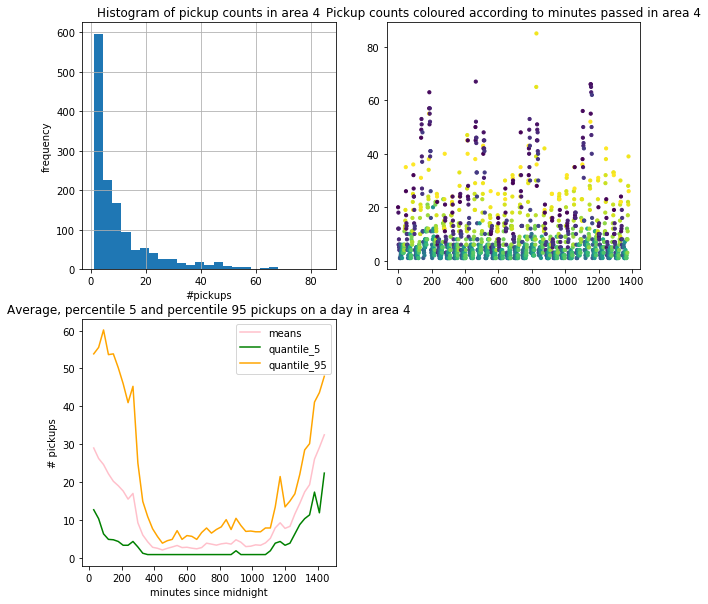

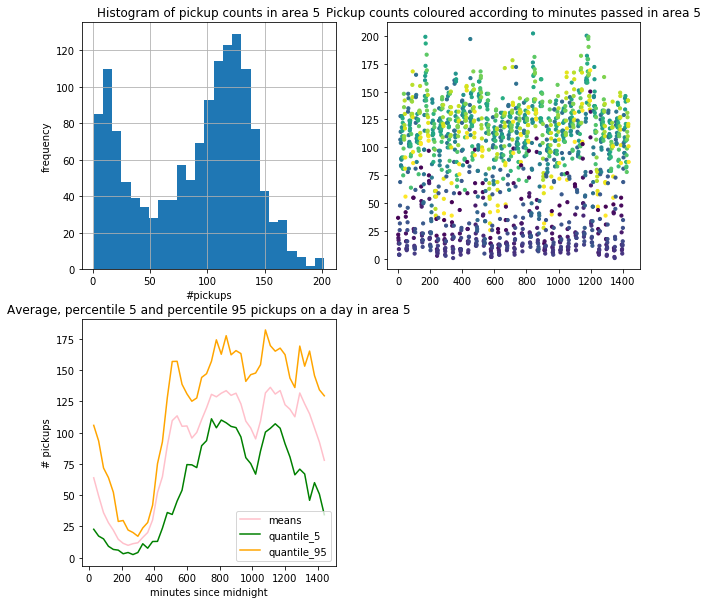

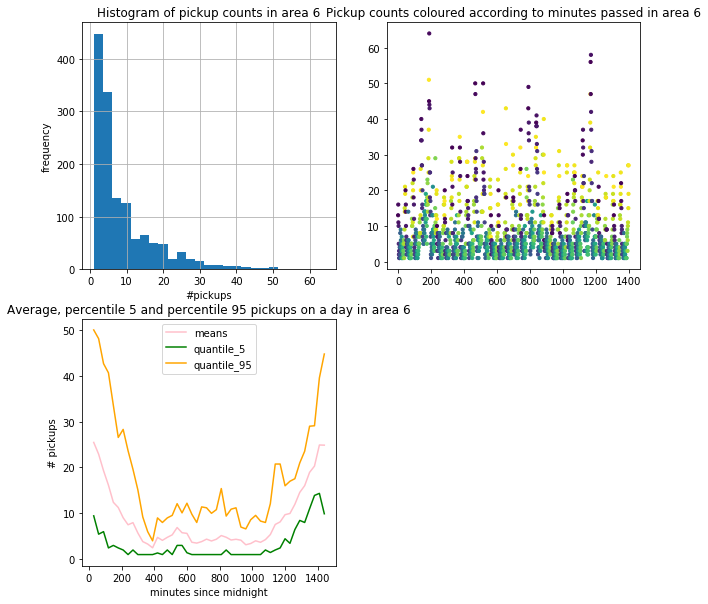

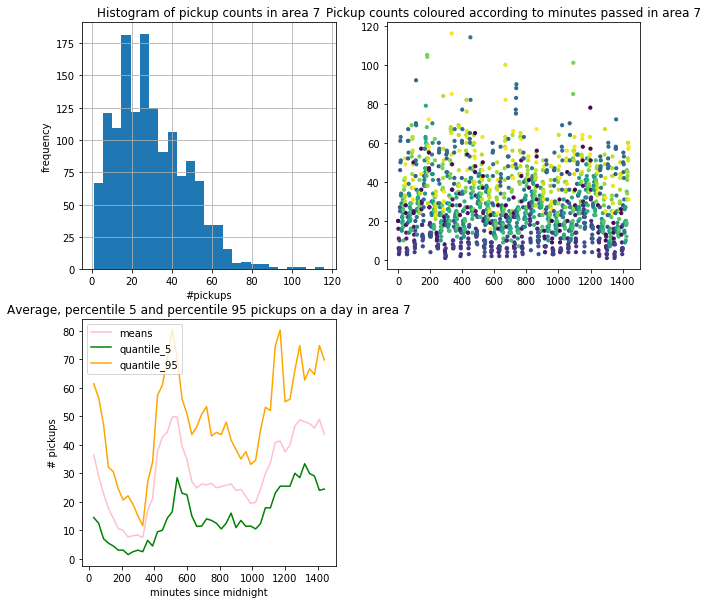

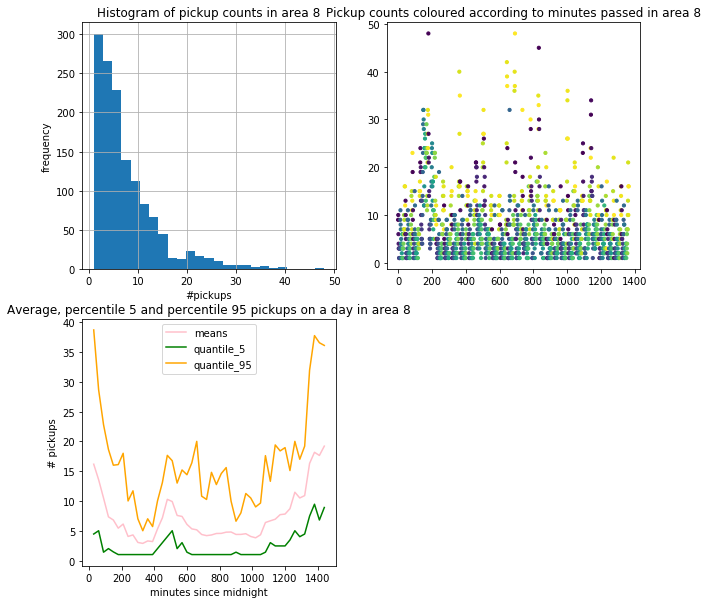

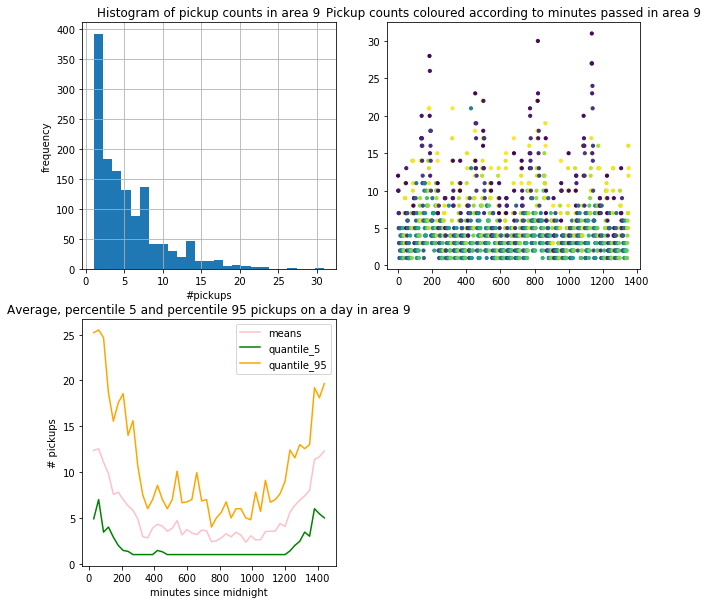

In [48]:
for k in list(pickupCountDict.keys()):
    plots(pickupCountDict[k], k)

In [49]:
def convertMinToTime(minutesDelta):
    if minutesDelta == 1440:
        return dt.time(0, 0)
    else:
        hours = minutesDelta //60
        minutes = minutesDelta % 60
        return dt.time(hours, minutes)


In [50]:
def recombinedDatetimeCol(df):
    df['timetime'] = df['min_since_midnight'].apply(lambda x: convertMinToTime(x))
    df['datetime'] = [dt.datetime.combine(d, t) for d, t in zip(df['date'], df['timetime'])]
    del df['min_since_midnight']
    del df['date']
    df = df.set_index('datetime')
    return df

In [51]:
mergedPickupCountClustersRecombinedDT = recombinedDatetimeCol(mergedPickupCountClusters.copy())

In [52]:
# todo: fix x and y labels
def draw_correlation_matrix(corrDf):
    print(corrDF)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 15)
    cax = ax1.imshow(corrDf, interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation between pickup areas')
    labels=list(corrDf.columns)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax1.set_xticklabels(labels,fontsize=5)
    ax1.set_yticklabels(labels,fontsize=8)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-.3,-.2,-.1,.0,.1,.2,.3,.4,.5, .6,.7, .8,.90,1])
    plt.show()

          count_0   count_1   count_2   count_3   count_4   count_5   count_6  \
count_0  1.000000 -0.224205  0.430181  0.038896  0.845472 -0.325954  0.700207   
count_1 -0.224205  1.000000  0.355728  0.444816  0.000673  0.898076  0.172484   
count_2  0.430181  0.355728  1.000000  0.493842  0.650064  0.233855  0.779931   
count_3  0.038896  0.444816  0.493842  1.000000  0.194348  0.441142  0.373263   
count_4  0.845472  0.000673  0.650064  0.194348  1.000000 -0.139396  0.822883   
count_5 -0.325954  0.898076  0.233855  0.441142 -0.139396  1.000000  0.033558   
count_6  0.700207  0.172484  0.779931  0.373263  0.822883  0.033558  1.000000   
count_7 -0.036416  0.682859  0.548317  0.773867  0.168707  0.639823  0.376855   
count_8  0.410228  0.296911  0.783614  0.563794  0.558225  0.224205  0.692004   
count_9  0.726474 -0.006520  0.623737  0.283754  0.785487 -0.115090  0.771801   

          count_7   count_8   count_9  
count_0 -0.036416  0.410228  0.726474  
count_1  0.682859  0.296911 

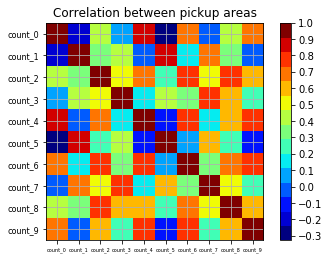

In [53]:
corrDF = mergedPickupCountClustersRecombinedDT.corr()
draw_correlation_matrix(corrDF)

As one can see in the legend, the more red-ish the fields are, the more are the pickups correlated. There seems to be very high correlations between the following areas:
- 0 and 4
- 1 and 5

And quite high correlations between the areas:
- 0 and 6
- 0 and 8
- 2 and 6
- 2 and 8
- 3 and 7

Now, the correlations between the lagged counts are to be examined:

In [54]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [55]:
countCols = [col for col in mergedPickupCountClustersRecombinedDT.columns if 'count_' in col]
mergedPickupCountsLagged = buildLaggedFeatures(mergedPickupCountClustersRecombinedDT, countCols)

In [62]:
def draw_correlation_matrix_for_lags(corrDf):
    print(corrDF)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(corrDf, interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation between pickup areas and their lags')
    labels=list(corrDf.columns)
    ax1.set_xticks(list(range(0,len(corrDf))))
    ax1.set_yticks(list(range(0,len(corrDf))))
    ax1.set_xticklabels(labels,fontsize=5)
    ax1.set_yticklabels(labels,fontsize=8)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-.3,-.2,-.1,.0,.1,.2,.3,.4,.5, .6,.7, .8,.90,1])
    plt.show()

          count_0   count_1   count_2   count_3   count_4   count_5   count_6  \
count_0  1.000000 -0.224205  0.430181  0.038896  0.845472 -0.325954  0.700207   
count_1 -0.224205  1.000000  0.355728  0.444816  0.000673  0.898076  0.172484   
count_2  0.430181  0.355728  1.000000  0.493842  0.650064  0.233855  0.779931   
count_3  0.038896  0.444816  0.493842  1.000000  0.194348  0.441142  0.373263   
count_4  0.845472  0.000673  0.650064  0.194348  1.000000 -0.139396  0.822883   
count_5 -0.325954  0.898076  0.233855  0.441142 -0.139396  1.000000  0.033558   
count_6  0.700207  0.172484  0.779931  0.373263  0.822883  0.033558  1.000000   
count_7 -0.036416  0.682859  0.548317  0.773867  0.168707  0.639823  0.376855   
count_8  0.410228  0.296911  0.783614  0.563794  0.558225  0.224205  0.692004   
count_9  0.726474 -0.006520  0.623737  0.283754  0.785487 -0.115090  0.771801   

          count_7   count_8   count_9  
count_0 -0.036416  0.410228  0.726474  
count_1  0.682859  0.296911 

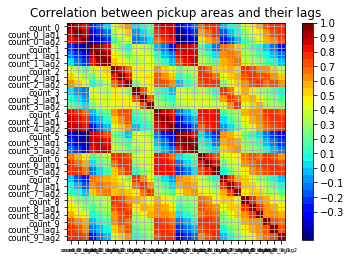

In [63]:
draw_correlation_matrix_for_lags(mergedPickupCountsLagged.corr())

As one can see, there is a very high correlation between
- area 0 and lags 1 and 2 of area 4
- area 1, area 5, and lag 1 of area 5

In [92]:
x=np.c_[np.ones(len(mergedPickupCountsLagged)),mergedPickupCountsLagged['count_4_lag1'], mergedPickupCountsLagged['count_4_lag2']]
y=np.array(mergedPickupCountsLagged['count_0'], ndmin=2).T

In [93]:
len(y)

1060

In [94]:
def compute_error(y_true, y_pred, nvariables = 2):
    corr = np.corrcoef(y_pred[:,0], y_true[:,0])[0,1]
    rho2 = pearsonr(y_pred, y_true)[0]
    mae = np.mean(np.abs(y_pred - y_true))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))
    r_squared = max(0, 1 - np.sum((y_true-y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    adjustedr2 = 1 - (1-r_squared)*(len(y_true)-1)/(len(y_true)-nvariables-1)
    return  corr, rho2, mae, mape, rmse, r_squared, adjustedr2

In [95]:
regr=linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)
corr, rho2, mae, mape, rmse, r_squared, adjustedr2 = compute_error(y, regr.predict(x))

print('---Linear Regression Scores---')
print("Pearson’s correlation coefficient = ", rho2[0])
print("Mean Absolute Error = ", mae)
print("Mean Absolute Percentage Error = ", mape)
print("R-squared = ", r_squared)
print("Adjusted R-squared = ", adjustedr2)
print("Root Mean Squared Error = ", rmse)

---Linear Regression Scores---
Pearson’s correlation coefficient =  0.894968285854
Mean Absolute Error =  3.60240963899
Mean Absolute Percentage Error =  64.2367191178
R-squared =  0.800968232684
Adjusted R-squared =  0.800591635206
Root Mean Squared Error =  5.71166431217


In [115]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean absolute error    
print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
# The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))

IndentationError: unexpected indent (<ipython-input-115-6f95cbc0d2f5>, line 2)

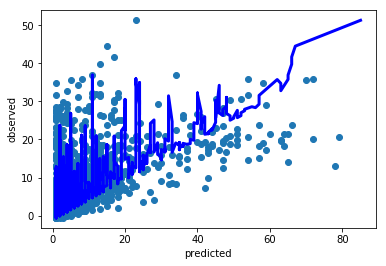

In [114]:
plt.scatter(y, regr.predict(x))
plt.plot(x[:,1], regr.predict(x), color='blue',linewidth=3)
plt.xlabel("predicted")
plt.ylabel("observed")
plt.show()

It looks like a linear regression is not too bad...